### Want to see: example units, how firing changes relative to block position, in blocks with different rules
Getting promising results in examine_value_agg_glms plots. 
Methods: 
- Always look at mean subtracted firing rates
- Plot as function of relative block position (or max value bin? idk)
- Find hidden rules based on examine_value_agg_glms plots

In [1]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
from constants.glm_constants import *
from constants.behavioral_constants import *
from spike_tools import (
    general as spike_general,
    analysis as spike_analysis,
)
from scipy import stats
import warnings
from scipy.ndimage import gaussian_filter1d

warnings.filterwarnings('ignore')

In [2]:
OUTPUT_DIR = "/data/patrick_res/glm_2"
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"
sessions = pd.read_pickle(SESSIONS_PATH)

In [16]:
num_bins = 5
mode = "FiringRate"
def fr_by_block(row, features):
    session = row.session

    behavior_path = SESS_BEHAVIOR_PATH.format(sess_name=session)
    beh = pd.read_csv(behavior_path)

    # filter trials 
    valid_beh = behavioral_utils.get_valid_trials(beh)
    feature_selections = behavioral_utils.get_selection_features(valid_beh)
    valid_beh = pd.merge(valid_beh, feature_selections, on="TrialNumber", how="inner")
    beh = behavioral_utils.get_feature_values_per_session(session, valid_beh)
    beh = behavioral_utils.get_relative_block_position(beh, num_bins)
    beh = behavioral_utils.get_max_feature_value(beh, num_bins, quantize_bins=True)

    fr_path = f"/data/patrick_res/firing_rates/{session}_firing_rates_{PRE_INTERVAL}_{EVENT}_{POST_INTERVAL}_{INTERVAL_SIZE}_bins_{NUM_BINS_SMOOTH}_smooth.pickle"

    frs = pd.read_pickle(fr_path)
    frs = frs[frs.UnitID == row.UnitID]
    agg = frs.groupby(["UnitID", "TrialNumber"]).mean().reset_index()
    merged = pd.merge(agg, beh, on="TrialNumber")
    merged = spike_utils.mean_sub_frs(merged, group_cols=["UnitID", "BlockNumber"], mode=mode)
    merged = spike_utils.zscore_frs(merged, group_cols=["UnitID", "BlockNumber"], mode=mode)

    # merged = spike_utils.block_lowest_val_sub_frs(merged, mode=mode)

    fig, ax = plt.subplots()
    for feat in features:
        rule_blocks = merged[merged.CurrentRule == feat]
        rule_blocks = behavioral_utils.get_max_feature_value(rule_blocks, num_bins, quantize_bins=True)

        num_blocks = len(rule_blocks.BlockNumber.unique())
        print(feat)
        # visualization_utils.plot_mean_sterrs_by_bin(rule_blocks, f"FiringRate", "MaxValueBin", ax, f"{feat}, {num_blocks} blocks", num_bins)
        # visualization_utils.plot_mean_sterrs_by_bin(rule_blocks, f"LowestSub{mode}", "BlockPositionBin", ax, f"{feat}, {num_blocks} blocks", num_bins)
        visualization_utils.plot_mean_sterrs_by_bin(rule_blocks, f"Z{mode}", "MaxValueBin", ax, f"{feat}, {num_blocks} blocks", num_bins)

    ax.legend()



In [17]:
positions = spike_utils.get_unit_positions(sessions)

MAGENTA
POLKADOT


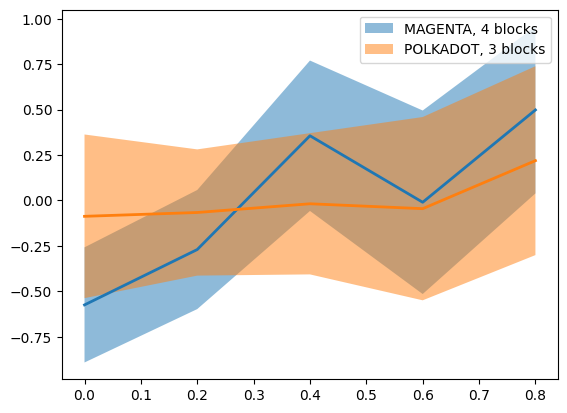

In [21]:
unit = 2018100100
features = ["MAGENTA", "POLKADOT"]
row = positions[positions.PseudoUnitID == unit].iloc[0]
fr_by_block(row, features)

ESCHER
POLKADOT


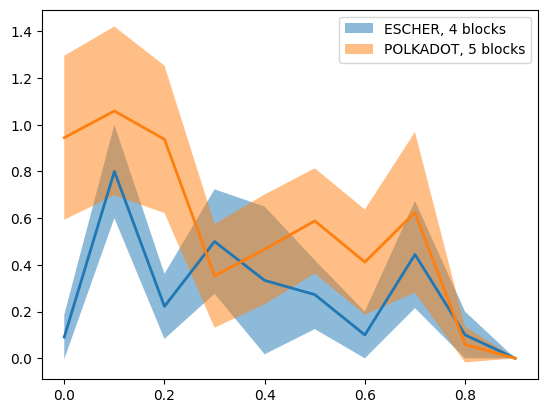

In [33]:
unit = 2018092006
features = ["ESCHER", "POLKADOT"]
row = positions[positions.PseudoUnitID == unit].iloc[0]
fr_by_block(row, features)

RIPPLE
ESCHER


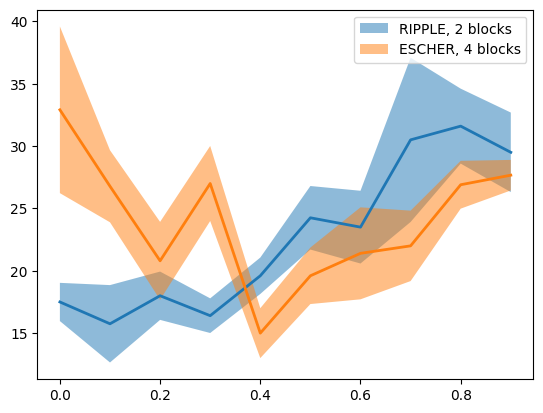

In [34]:
unit = 2018091007
features = ["RIPPLE", "ESCHER"]
row = positions[positions.PseudoUnitID == unit].iloc[0]
fr_by_block(row, features)